In [ ]:
!pip install pyg_lib torch_scatter torch_cluster torch-sparse torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install torch_geometric

In [ ]:
import geopandas as gpd
from torch_geometric.data import HeteroData
import pandas as pd
import numpy as np
import torch
import pickle
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import math
import warnings
warnings.filterwarnings('ignore')

In [ ]:
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/MH_proc.pkl', "rb") as f:
    MH = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Road_proc.pkl', "rb") as f:
    Road = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/MH_R_RL_proc.pkl', "rb") as f:
    MH_R_RL = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Line_proc.pkl', "rb") as f:
    Line = pickle.load(f)
# with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/MH_MH_proc.pkl', "rb") as f:
#     MH_MH_RL = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/R_R_proc.pkl', "rb") as f:
    R_R_RL = pickle.load(f)
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/split_mask.pkl', "rb") as f:
    split = pickle.load(f)

In [ ]:
len(MH), len(Road), len(Line)

(206187, 32080, 203203)

In [ ]:
%cd /content/drive/MyDrive/0Network_PipeLine_Predcition
from Module.LocationEncoder import TheoryGridCellSpatialRelationEncoder

location_encoder = TheoryGridCellSpatialRelationEncoder(spa_embed_dim = 128, device = 'cuda')

/content/drive/MyDrive/0Network_PipeLine_Predcition


In [ ]:
train_set = set.union(*split['train'])
val_set = set.union(*split['val'])
test_set = set.union(*split['test'])

In [ ]:
from Module.dataset import dataset
train_data, train_line_index = dataset(MH, Line, Road, MH_R_RL, R_R_RL, train_set)
val_data, val_line_index = dataset(MH, Line, Road, MH_R_RL, R_R_RL, val_set)
test_data, test_line_index = dataset(MH, Line, Road, MH_R_RL, R_R_RL, test_set)

In [ ]:
import pickle

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/train_data.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(train_data, file)

    # Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/val_data.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(val_data, file)

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/test_data.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(test_data, file)

In [ ]:
import pickle

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/train_data.pkl', 'rb') as file:

    # A new file will be created
    train_data = pickle.load(file)

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/val_data.pkl', 'rb') as file:

    # A new file will be created
    val_data = pickle.load(file)

# Open a file and use dump()
with open('/content/drive/MyDrive/0Network_PipeLine_Predcition/Data/test_data.pkl', 'rb') as file:

    # A new file will be created
    test_data = pickle.load(file)

In [ ]:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data['MH','link','MH'].edge_label_index
edge_label = train_data['MH','link','MH'].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=0,
    edge_label_index=(('MH','link','MH'), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero, GATConv, HeteroConv
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.data import HeteroData


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATConv((-1, -1), hidden_channels, dropout = 0, add_self_loops = False)
        self.conv2 = GATConv(hidden_channels, hidden_channels, dropout = 0, add_self_loops = False)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)
        return x
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_MH: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_line1 = x_MH[edge_label_index[0]]
        edge_feat_line2 = x_MH[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_line1 * edge_feat_line2).sum(axis = -1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Instantiate homogeneous GNN:
        self.linear = torch.nn.Linear(96, hidden_channels)
        self.gnn = GNN(hidden_channels)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=train_data.metadata())
        self.classifier = Classifier()
    def forward(self, data: HeteroData) -> Tensor:
        # `x_dict` holds feature matrices of all node types
        center = torch.mean(torch.concat([data.x_dict["MH"][:,:2], data.x_dict["Road"][:,:2]]), axis = 0)
        disp = {
            "MH": location_encoder((data.x_dict["MH"][:,:2] - center).reshape(-1, 1, 2)).reshape(-1, 96),
            "Road": location_encoder((data.x_dict["Road"][:,:2] - center).reshape(-1, 1, 2)).reshape(-1, 96),
            }
        x_dict = {
        "MH": torch.concat([F.relu(self.linear(disp["MH"])), data.x_dict["MH"][:,2:]], axis = 1),
        "Road": torch.concat([F.relu(self.linear(disp["Road"])),data.x_dict["Road"][:,2:]], axis = 1),
        }
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        pred = self.classifier(
            x_dict["MH"],
            data["MH", "link", "MH"].edge_label_index,
        )
        return pred

model = Model(hidden_channels=128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = model.to(device)

Device: 'cuda'


In [ ]:
import tqdm
import torch.nn.functional as F
import pyg_lib
import torch_sparse
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(5):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data)
        ground_truth = sampled_data["MH", "link", "MH"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

In [ ]:
from torch_geometric.loader import LinkNeighborLoader
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import tqdm
sampled_data = next(iter(train_loader))
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(train_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["MH", "link", "MH"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Training AUC: {auc:.4f}")

100%|██████████| 1963/1963 [00:28<00:00, 67.88it/s]



Training AUC: 0.9557


In [ ]:
from torch_geometric.loader import LinkNeighborLoader
# Define the validation seed edges:
edge_label_index = val_data["MH", "link", "MH"].edge_label_index
edge_label = val_data["MH", "link", "MH"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20,10],
    edge_label_index=(("MH", "link", "MH"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=False,
)
sampled_data = next(iter(val_loader))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import tqdm
preds = []
ground_truths = []
model = model.to(device)
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["MH", "link", "MH"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")
torch.save(model.state_dict(), '/content/drive/MyDrive/0Network_PipeLine_Predcition/Models/model_hiddensize_128_drop_02.pt')

100%|██████████| 534/534 [00:08<00:00, 63.57it/s]



Validation AUC: 0.9465


In [ ]:
model.state_dict()['gnn.conv1.MH__near__Road.bias'].shape

torch.Size([64])

In [ ]:
# Define the testing seed edges:
edge_label_index = test_data["MH", "link", "MH"].edge_label_index
edge_label = test_data["MH", "link", "MH"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("MH", "link", "MH"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)
testing_data = next(iter(test_loader))

In [ ]:
from sklearn.metrics import roc_auc_score
import tqdm
preds = []
device = 'cuda'
model = model.to(device)
ground_truths = []
for testing_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        testing_data.to(device)
        preds.append(model(testing_data))
        ground_truths.append(testing_data["MH", "link", "MH"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Testing AUC: {auc:.4f}")

100%|██████████| 227/227 [00:04<00:00, 48.70it/s]


Testing AUC: 0.9412


NameError: ignored

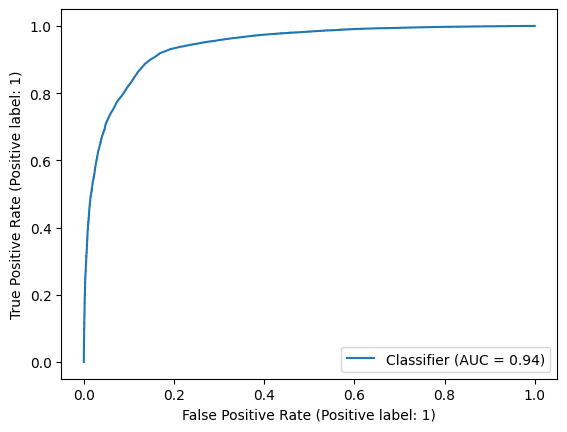

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(ground_truth, pred)

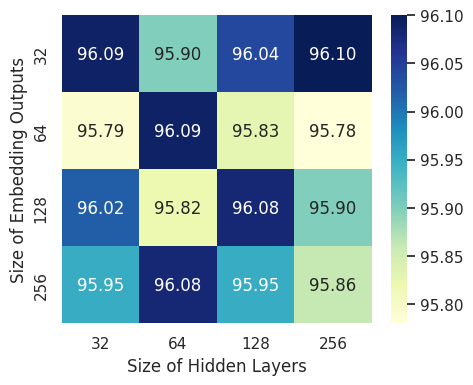

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from the table provided by the user
data_heat = {
    32: [0.9609, 0.9579, 0.9602, 0.9595],
    64: [0.9590, 0.9609, 0.9582, 0.9608],
    128: [0.9604, 0.9583, 0.9608, 0.9595],
    256: [0.9587, 0.9578, 0.9590, 0.9586]
}

# Convert the dictionary to a pandas DataFrame and multiply by 100 to get percentages
df_percentage = pd.DataFrame(data_heat, index=[32, 64, 128, 256]) * 100

# Increase font size for the heatmap
sns.set(font_scale=1)

# Create the heatmap with the updated font size and percentage values
plt.figure(figsize=(5, 4))
ax = sns.heatmap(df_percentage, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)

# Set the labels for the axes with updated font size
ax.set_ylabel('Size of Embedding Outputs')
ax.set_xlabel('Size of Hidden Layers')
# ax.set_title('ROC AUC Scores on Validation Data')

# Show the heatmap with larger font size
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/0Network_PipeLine_Predcition/Models/model_hiddensize_128_drop_0.pt'))

<All keys matched successfully>

In [ ]:
!pip install captum
from torch_geometric.explain import Explainer, CaptumExplainer

class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model.to('cpu')

    def forward(self, x_dict, edge_index_dict, edge_attr, edge_label_index):
        # Convert x_dict and edge_index_dict to the format expected by the original model
        data = HeteroData()
        data['MH'].node_id = torch.arange(x_dict['MH'].shape[0])
        data['MH'].x = x_dict['MH']
        data['Road'].node_id = torch.arange(x_dict['Road'].shape[0])
        data['Road'].x = x_dict['Road']
        data['Road','link','Road'].edge_index = edge_index_dict['Road','link','Road']
        data['MH','near','Road'].edge_index = edge_index_dict['MH','near','Road']
        data['MH','near','Road'].edge_attr = edge_attr['MH','near','Road']
        data['Road','rev_near','MH'].edge_index = edge_index_dict['Road','rev_near','MH']
        data['Road','rev_near','MH'].edge_attr = edge_attr['Road','rev_near','MH']
        data['MH','link','MH'].edge_index = edge_index_dict['MH','link','MH']
        data['MH','link','MH'].edge_label_index = edge_label_index
        data = data.to('cpu')
        return self.model(data)

explainer = Explainer(
    ModelWrapper(model),  # It is assumed that model outputs a single tensor.
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type='model',
    node_mask_type= 'attributes',
    edge_mask_type='object',
    model_config = dict(
        mode='binary_classification',
        task_level='edge',
        return_type='probs',  # Model returns probabilities.
    ),
)
# Generate batch-wise heterogeneous explanations for
# the nodes at index `1` and `3`:
hetero_explanation = explainer(
    test_data.x_dict,
    test_data.edge_index_dict,
    edge_attr =  test_data.edge_attr_dict,
    edge_label_index=test_data['MH','link','MH'].edge_index,
    index=torch.arange(test_data['MH', 'link', 'MH']['edge_index'].shape[1]),
)
print(hetero_explanation.edge_mask_dict)
print(hetero_explanation.node_mask_dict)

In [ ]:
hetero_explanation.node_mask_dict['MH'][4,:]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)

In [ ]:
pd.get_dummies(Road, columns = ['OVL2_CAT','angle_bin','len_bins']).iloc[:,6:]

,x_coordinate,y_coordinate,OVL2_CAT_INF_AR,OVL2_CAT_INF_ARF,OVL2_CAT_INF_DR,OVL2_CAT_INF_DRF,OVL2_CAT_INF_MW,OVL2_CAT_INF_MWF,OVL2_CAT_INF_NR,OVL2_CAT_INF_SR,...,angle_bin_1,angle_bin_2,angle_bin_3,angle_bin_4,angle_bin_5,len_bins_0,len_bins_1,len_bins_2,len_bins_3,len_bins_4
0,153.046880,-27.360770,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,153.032754,-27.358692,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,153.026615,-27.526821,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,153.075874,-27.559673,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,153.041644,-27.461686,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32075,153.100259,-27.610863,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
32076,153.100983,-27.611122,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
32077,153.100740,-27.612121,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
32078,153.101538,-27.612323,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


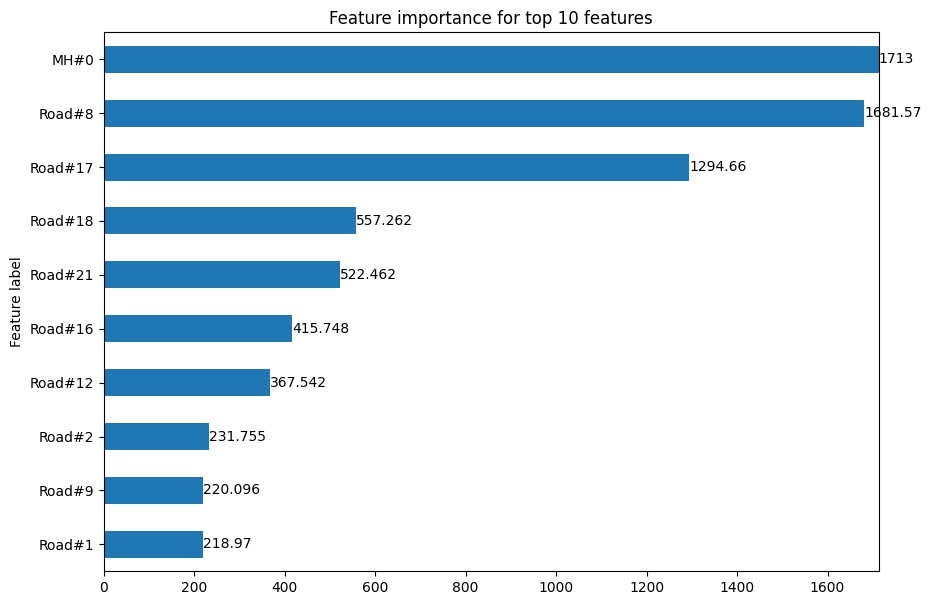

In [ ]:
hetero_explanation.visualize_feature_importance(top_k= 10)

In [ ]:
test_data['Road'].x[:,8]

tensor([1., 1., 1.,  ..., 1., 0., 0.])

In [ ]:
Road

,OVL_CAT,OVL2_CAT,ROUTE_TYPE,Shape_Leng,geometry,FID,angle,angle_bin,len_bins,x_coordinate,y_coordinate
0,DEV,INF_SR,Suburban,481.066503,"LINESTRING (504871.715 6973565.342, 504869.361...",1,99.936905,3,4,153.046880,-27.360770
1,DEV,INF_SR,Suburban,87.895244,"LINESTRING (503280.683 6973828.793, 503267.352...",2,101.808628,3,1,153.032754,-27.358692
2,DEV,INF_NR,Neighbourhood / local,91.428485,"LINESTRING (502633.838 6955261.638, 502625.328...",7,7.404171,0,1,153.026615,-27.526821
3,DEV,INF_NR,Neighbourhood / local,390.712052,"LINESTRING (507623.951 6951502.633, 507541.212...",8,142.206677,5,4,153.075874,-27.559673
4,DEV,INF_NR,Neighbourhood / local,61.140393,"LINESTRING (504136.940 6962410.902, 504090.607...",9,130.727629,4,0,153.041644,-27.461686
...,...,...,...,...,...,...,...,...,...,...,...
32075,DEV,INF_NR,Neighbourhood / local,92.877474,"LINESTRING (509884.183 6945857.684, 509899.709...",41748,9.622987,0,1,153.100259,-27.610863
32076,DEV,INF_NR,Neighbourhood / local,92.877491,"LINESTRING (509955.579 6945828.970, 509971.105...",41749,9.623048,0,1,153.100983,-27.611122
32077,DEV,INF_NR,Neighbourhood / local,224.853983,"LINESTRING (509864.538 6945729.358, 509871.192...",41750,54.833807,2,3,153.100740,-27.612121
32078,DEV,INF_NR,Neighbourhood / local,70.008210,"LINESTRING (510052.546 6945735.905, 509983.488...",41751,99.447737,3,0,153.101538,-27.612323


In [ ]:
hetero_explanation.get_explanation_subgraph()

HeteroExplanation(
  prediction=[65380],
  target=[65380],
  index=[65380],
  edge_label_index=[2, 65380],
  MH={
    node_mask=[82476, 22],
    x=[82476, 22],
  },
  Road={
    node_mask=[19519, 20],
    x=[19519, 20],
  },
  (MH, link, MH)={
    edge_mask=[3727],
    edge_index=[2, 3727],
  },
  (Road, link, Road)={
    edge_mask=[43500],
    edge_index=[2, 43500],
  },
  (MH, near, Road)={
    edge_mask=[55174],
    edge_index=[2, 55174],
    edge_attr=[55174, 7],
  },
  (Road, rev_near, MH)={
    edge_mask=[38109],
    edge_index=[2, 38109],
    edge_attr=[38109, 7],
  }
)

In [ ]:
data.edge_attr_dict

{('MH',
  'near',
  'Road'): tensor([[0.3604, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0956, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.9006, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.6130, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.6401, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.3130, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000]],
        dtype=torch.float64),
 ('Road',
  'rev_near',
  'MH'): tensor([[0.3604, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0956, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.9006, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.6130, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.6401, 1.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.3130, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000]],
        dtype=torch.float64)}

In [ ]:
from captum.attr import IntegratedGradients
from torch_geometric.data import HeteroData

from torch_geometric.nn import (captum_output_to_dicts,
                                to_captum_model, to_captum_input)

class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x_dict, edge_index_dict, edge_attr, edge_label_index):
        # Convert x_dict and edge_index_dict to the format expected by the original model
        data = HeteroData()
        data['MH'].node_id = torch.arange(x_dict['MH'].shape[0])
        data['MH'].x = x_dict['MH']
        data['Road'].node_id = torch.arange(x_dict['Road'].shape[0])
        data['Road'].x = x_dict['Road']
        data['Road','link','Road'].edge_index = edge_index_dict['Road','link','Road']
        data['MH','near','Road'].edge_index = edge_index_dict['MH','near','Road']
        data['MH','near','Road'].edge_attr = edge_attr['MH','near','Road']
        data['Road','rev_near','MH'].edge_index = edge_index_dict['Road','rev_near','MH']
        data['Road','rev_near','MH'].edge_attr = edge_attr['Road','rev_near','MH']
        data['MH','link','MH'].edge_index = edge_index_dict['MH','link','MH']
        data['MH','link','MH'].edge_label_index = edge_label_index
        data = data.to('cpu')
        self.model = self.model.to('cpu')
        return self.model(data)

# Explain predictions for MH-MH edge `10`:
mask_type="edge"
metadata = test_data.metadata()
output_idx = 1
captum_model = to_captum_model(ModelWrapper(model), mask_type, output_idx, metadata)
inputs, additional_forward_args = to_captum_input(test_data.x_dict,
    test_data.edge_index_dict, mask_type,
    test_data.edge_attr_dict,
    test_data['MH','link','MH'].edge_index)

ig = IntegratedGradients(captum_model)
ig_attr = ig.attribute(inputs=inputs,
                       target=None,
                       additional_forward_args=additional_forward_args,
                       internal_batch_size=1)
edge_attr_dict = captum_output_to_dicts(ig_attr, mask_type, metadata)

In [ ]:
tensor = hetero_explanation.edge_mask_dict['MH', 'link', 'MH']
nonzero_values = tensor[torch.argmax(tensor)]
nonzero_indices = torch.argmax(tensor).squeeze()

nonzero_values, nonzero_indices


(tensor(0.0409, dtype=torch.float64, grad_fn=<SelectBackward0>),
 tensor(164061))

In [ ]:
val_data['MH','link','MH'].edge_index[:,25292]

tensor([6514, 6614])

In [ ]:
tensor = hetero_explanation.node_mask_dict['Road']
nonzero_values = tensor[np.unravel_index(torch.argmax(tensor),tensor.shape)]
nonzero_indices = np.unravel_index(torch.argmax(tensor),tensor.shape)

nonzero_values, nonzero_indices

(tensor(0.0612, dtype=torch.float64), (7264, 18))

In [ ]:
from fiona.crs import from_epsg
Line.iloc[train_line_index].crs = from_epsg(4326)
Line.iloc[train_line_index].to_file('train.shp')
Line.iloc[val_line_index].crs = from_epsg(4326)
Line.iloc[val_line_index].to_file('val.shp')
Line.iloc[test_line_index].crs = from_epsg(4326)
Line.iloc[test_line_index].to_file('test.shp')

<Axes: >

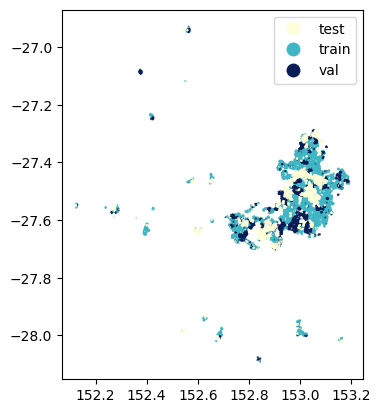

In [ ]:
from matplotlib import pyplot as plt
f, ax = plt.subplots()
train_df = Line.iloc[train_line_index]
val_df = Line.iloc[val_line_index]
test_df = Line.iloc[test_line_index]
train_df['label'] ='train'
val_df['label'] ='val'
test_df['label'] ='test'
gdf = pd.concat([train_df, val_df, test_df])
gdf.plot(ax=ax, column='label', legend=True, cmap='YlGnBu')

[(153.05, 153.1), (-27.58, -27.53)]

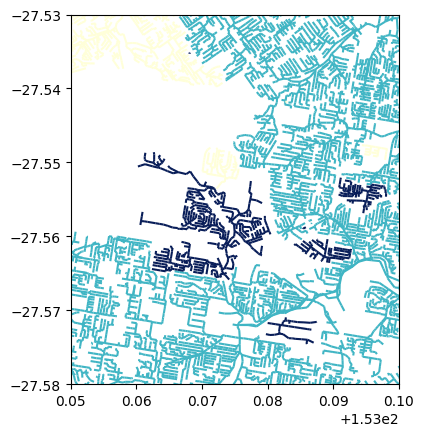

In [ ]:
f, ax = plt.subplots()
gdf.plot(ax=ax, column='label', cmap='YlGnBu')
ax.set(xlim=(153.05, 153.1), ylim=(-27.58, -27.53))

(0.0, 1.0) (0.0, 1.0)
(152.06942719315003, 153.2462533238501) (-28.15181574464997, -26.87053430034997)


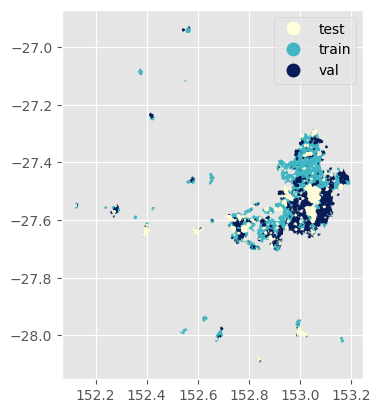

In [ ]:
f, ax = plt.subplots()
print(ax.get_xlim(), ax.get_ylim())
gdf.plot(ax=ax, column='label', legend=True, cmap='YlGnBu')
print(ax.get_xlim(), ax.get_ylim())

In [ ]:
Line.iloc[train_line_index].crs = from_epsg(4326)
Line.iloc[train_line_index].to_file('train.shp')

In [ ]:
# Define the testing seed edges:
edge_label_index = test_data["MH", "link", "MH"].edge_label_index
edge_label = test_data["MH", "link", "MH"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    edge_label_index=(("MH", "link", "MH"), edge_label_index),
    edge_label=edge_label,
    batch_size=1,
    shuffle=False,
)
testing_data = next(iter(test_loader))

In [ ]:
model(testing_data.to('cpu'))

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/fx/graph_module.py", line 274, in __call__
    return super(self.cls, obj).__call__(*args, **kwargs)  # type: ignore[misc]
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "<eval_with_key>.31", line 22, in forward
    conv1__MH = torch.add(conv1__MH1, conv1__MH2);  conv1__MH1 = conv1__MH2 = None
TypeError: add(): argument 'input' (position 1) must be Tensor, not tuple

Call using an FX-traced Module, line 22 of the traced Module's generated forward function:
    conv1__MH2 = self.conv1.Road__rev_near__MH((x__Road, x__MH), edge_index__Road__rev_near__MH, edge_attr__Road__rev_near__MH, return_attention_weights = True);  x__Road = x__MH = None
    con

TypeError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score
import tqdm
preds = []
device = 'cuda'
model = model.to(device)
ground_truths = []
for testing_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        testing_data.to(device)
        preds.append(model(testing_data))
        ground_truths.append(testing_data["MH", "link", "MH"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Testing AUC: {auc:.4f}")

  0%|          | 0/65380 [00:00<?, ?it/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/fx/graph_module.py", line 274, in __call__
    return super(self.cls, obj).__call__(*args, **kwargs)  # type: ignore[misc]
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "<eval_with_key>.25", line 22, in forward
    conv1__MH = torch.add(conv1__MH1, conv1__MH2);  conv1__MH1 = conv1__MH2 = None
TypeError: add(): argument 'input' (position 1) must be Tensor, not tuple

Call using an FX-traced Module, line 22 of the traced Module's generated forward function:
    conv1__MH2 = self.conv1.Road__rev_near__MH((x__Road, x__MH), edge_index__Road__rev_near__MH, edge_attr__Road__rev_near__MH, return_attention_weights

TypeError: ignored